# Project Description

The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. In this project we would conduct the evaluation, keeping the following in mind: The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol Computer vision methods can be used to determine age of a person from a photo. The goal is to build and evaluate a model for verifying people's age.

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
#Loading the data

data = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale = 1./255)

train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe = data,
    directory = '/datasets/faces/final_files/',
    x_col = 'file_name',
    y_col = 'real_age',
    target_size = (215, 215),
    batch_size = 16,
    class_mode = 'raw',
    subset = 'training',
    seed = 12345
)


Found 7591 validated image filenames.


In [3]:
# Getting information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
#defining features and targets
features, target = next(train_datagen_flow) 
features.shape

(16, 215, 215, 3)

Batch size of 16 images, each having 215 by 215 dimensions with 3 channels

## EDA

In [5]:
#Getting the numerical description of the real ages in the dataset

data['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Text(0, 0.5, 'frequency')

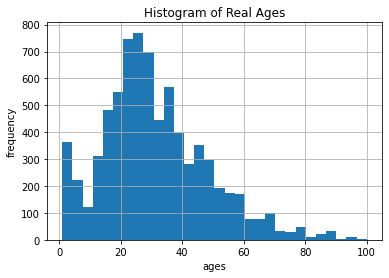

In [6]:
#Distribution of ages in the dataset

data['real_age'].hist(bins=30)
plt.title('Histogram of Real Ages')
plt.xlabel('ages')
plt.ylabel('frequency')

Most ages lie between 20 - 40 years old.

Let's take a look at the boxplot.

Text(0.5, 0, 'real_age')

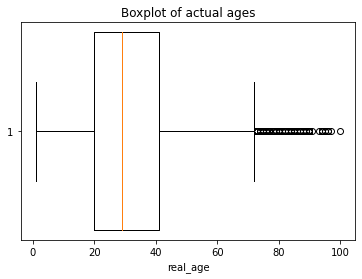

In [8]:
plt.boxplot(data['real_age'], vert=False, widths=1.2)
plt.title('Boxplot of actual ages')
plt.xlabel('real_age')

From the boxplot the dataset is skewed to the right since the median (29) is less than the mean (31)

Taking a look at the first fifteen images in the dataset

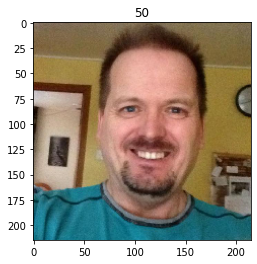

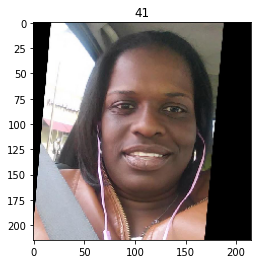

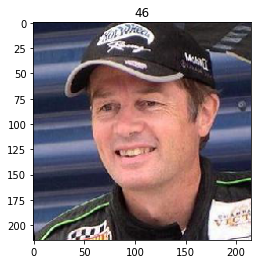

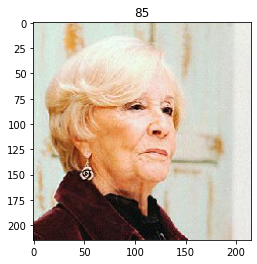

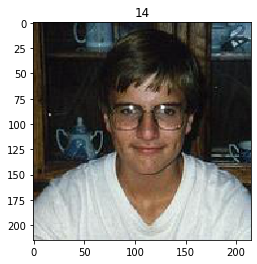

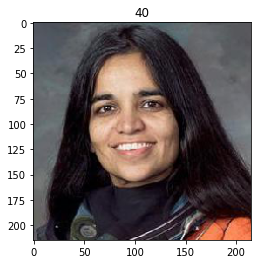

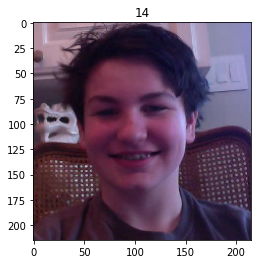

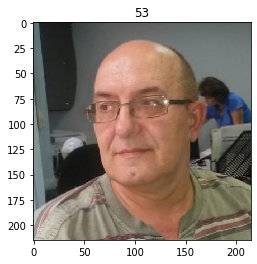

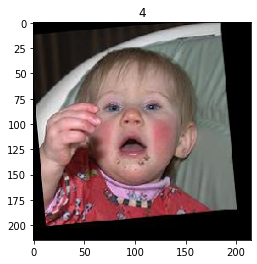

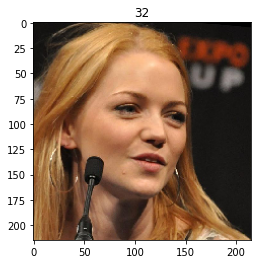

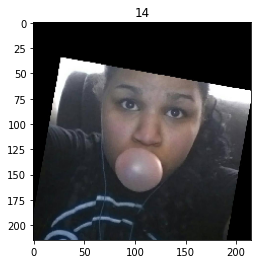

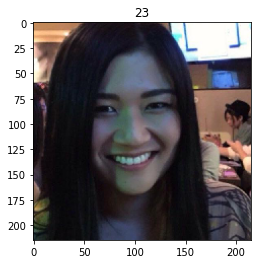

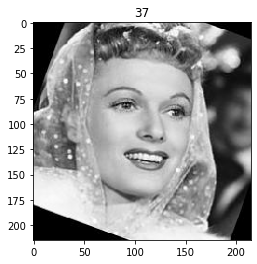

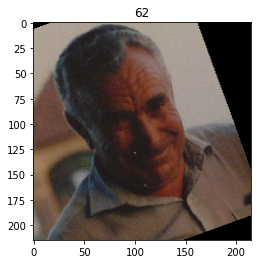

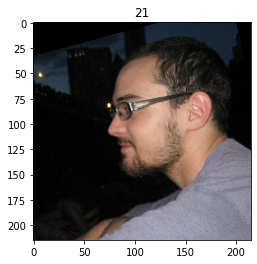

In [10]:
for age, pic in zip(target[:15], features[:15]):
    plt.figure()
    plt.title(age)
    plt.imshow(pic)

In this array of photos, almost all age groups are represented, ages ranging from age 4 to age 85. Some pictures are slanted, and this is quite helpful in training the model.

### Findings

We found that the bulk of the ages lie between 20 and 40. The mean is 31, and the median is 29, which makes the distribution skewed to the right.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you explored the data a bit and checked target distribution

</div>

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [11]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [16]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    data = pd.read_csv(path + 'data.csv')
    train_datagen = ImageDataGenerator(rescale = 1./255, 
                                       validation_split = 0.25,
                                      horizontal_flip = True, 
                                      width_shift_range = 0.2,
                                      height_shift_range = 0.2,
                                      rotation_range = 20,
                                      zoom_range = 0.2)
    train_gen_flow = train_datagen.flow_from_dataframe(
                    dataframe = data,
                    directory = path + 'final_files/',
                    x_col = 'file_name',
                    y_col = 'real_age',
                    target_size = (225, 225),
                    batch_size = 32,
                    class_mode = 'raw',
                    subset = 'training',
                    seed = 12345)

    return train_gen_flow

In [17]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    data = pd.read_csv(path + 'data.csv')
    test_datagen = ImageDataGenerator(validation_split = 0.25, rescale = 1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
                dataframe = data,
                directory = path + 'final_files/',
                x_col = 'file_name',
                y_col = 'real_age',
                target_size = (225, 225),
                batch_size = 32,
                class_mode = 'raw',
                subset = 'validation',
                seed = 12345)
    
    

    return test_gen_flow

<div class="alert alert-success">
<b>Reviewer's comment</b>

The code for data loading is correct. Good idea to add augmentations for the training data!

</div>

In [19]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    backbone = ResNet50(weights='imagenet',  # Kept the weights as 'imagenet' for transfer learning benefits
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, 
                  loss='mse', 
                  metrics=['mae'])

    
    # place your code here

    return model

In [20]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    # Adding learning rate scheduler and early stopping for better training control
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=0.000001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    callbacks = [lr_scheduler, early_stopping]

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              callbacks=callbacks)  # Added the callbacks here

    return model

    return model

We used the ResNet50 architecture pretrained by the ImageNet database. We chose the Adam algorithm as an optimizer and set the learning rate to 0.0005 for more quality.
We added the learning rate scheduler and early stopping parameters for better training control.

Our loss function will be the mean squared error, and our metric will be the mean absolute error since this is a regression task

<div class="alert alert-success">
<b>Reviewer's comment</b>

The model is defined and trained correctly

</div>

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [ ]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Train for 190 steps, validate for 60 steps
Epoch 1/20
2023-10-15 00:12:25.222596: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-10-15 00:12:26.067276: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 81s - loss: 228.5841 - mae: 11.3295 - val_loss: 458.5681 - val_mae: 16.3318
Epoch 2/20
190/190 - 65s - loss: 148.2764 - mae: 9.3308 - val_loss: 327.1688 - val_mae: 13.4059
Epoch 3/20
190/190 - 65s - loss: 127.6751 - mae: 8.5975 - val_loss: 386.0152 - val_mae: 14.6459
Epoch 4/20
190/190 - 65s - loss: 124.3274 - mae: 8.5183 - val_loss: 241.6119 - val_mae: 11.2668
Epoch 5/20
190/190 - 65s - loss: 114.0948 - mae: 8.1002 - val_loss: 255.7304 - val_mae: 10.7846
Epoch 6/20
190/190 - 65s - loss: 114.9399 - mae: 8.1228 - val_loss: 92.1736 - val_mae: 7.3040
Epoch 7/20
190/190 - 65s - loss: 101.5499 - mae: 7.6611 - val_loss: 89.9538 - val_mae: 7.3210
Epoch 8/20
190/190 - 65s - loss: 98.5387 - mae: 7.5108 - val_loss: 106.2624 - val_mae: 7.7337
Epoch 9/20
190/190 - 64s - loss: 95.4279 - mae: 7.4183 - val_loss: 166.9479 - val_mae: 10.0470
Epoch 10/20
190/190 - 64s - loss: 88.2604 - mae: 7.1249 - val_loss: 172.7540 - val_mae: 9.0854
Epoch 11/20
190/190 - 64s - loss: 90.5082 - mae: 7.2289 - val_loss: 83.5817 - val_mae: 6.9835
Epoch 12/20
190/190 - 65s - loss: 82.2898 - mae: 6.8601 - val_loss: 106.1275 - val_mae: 7.5329
Epoch 13/20
190/190 - 64s - loss: 89.0513 - mae: 7.1373 - val_loss: 87.1389 - val_mae: 7.2468
Epoch 14/20
190/190 - 64s - loss: 78.3131 - mae: 6.7048 - val_loss: 95.8447 - val_mae: 7.6192
Epoch 15/20
190/190 - 64s - loss: 76.0000 - mae: 6.6176 - val_loss: 90.3902 - val_mae: 7.2306
Epoch 16/20

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
190/190 - 64s - loss: 78.0427 - mae: 6.6802 - val_loss: 88.2576 - val_mae: 7.0983
Epoch 17/20
190/190 - 64s - loss: 63.6502 - mae: 6.0102 - val_loss: 108.4135 - val_mae: 7.4586
Epoch 18/20
190/190 - 65s - loss: 54.9257 - mae: 5.6490 - val_loss: 64.2824 - val_mae: 5.9666
Epoch 19/20
190/190 - 65s - loss: 53.3749 - mae: 5.5452 - val_loss: 61.5925 - val_mae: 5.9213
Epoch 20/20
190/190 - 65s - loss: 48.4638 - mae: 5.3099 - val_loss: 64.8161 - val_mae: 6.0555
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 64.8161 - mae: 6.0555
Test MAE: 6.0555





<div class="alert alert-success">
<b>Reviewer's comment</b>

The model was trained successfully!

</div>

We achieved an MAE of 6.0555

## Conclusions

We analyzed the data and noticed a distribution skewed to the right (median of 29 less than mean of 31). The most popular age interval in the dataset was between 20 and 40. We trained a model using ResNet50 architecture and got an MAE of 6.45. A better score could probably be achieved using ResNet101 or ResNet152 and if we had a sample that was more balanced with the ages.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Very good!

</div>